# Calculate Customer Lifetime Value

This analysis is based on cohort-level.

**Dataset Information:**

The csv file has paying member historical data arranged by Policy_number from January 2015 to December 2019.

**Attribute Information:**
-	Start Date, Start Month and Churn Date of the policy
-	Number of members per policy 
-	Maximum duration that the plan allows 
-	State of the policy holder
-	Insurance carrier or provider of the policy 

# Data loading

In [357]:
#Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as plt
import math
# continuous target evaluation
from sklearn.metrics import explained_variance_score
from sklearn.metrics import max_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings("ignore")
# print out common metrics to evaluate regression models
def evaluation(y_true, y_predicted):
    print('root mean square error: ',np.round(np.sqrt(mean_squared_error(y_true, y_predicted)),2))
    print('mean square error: ', np.round(mean_squared_error(y_true, y_predicted),2))
    print('explained_variance_score: ', np.round(explained_variance_score(y_true, y_predicted),2))
    print('max_error: ', np.round(max_error(y_true, y_predicted),2))
    print('mean_absolute_error: ', np.round(mean_absolute_error(y_true, y_predicted),2))
    print('median_absolute_error: ', np.round(median_absolute_error(y_true, y_predicted),2))

In [2]:
#Import Data
df=pd.read_csv("cohort.csv", encoding="cp1252")
df.head()

,POLICY_NUMBER,START_DATE,START_MONTH,CHURN_DATE,MEMBERS,MAX_DURATION,STATE,CARRIER_NAME
0,97662795,1-Apr-16,4,1-Oct-16,1,184,AZ,CARRIER2
1,100915150,1-Dec-16,12,1-Dec-16,1,180,OR,CARRIER1
2,99747655,1-Oct-16,10,1-Mar-17,1,180,NC,CARRIER3
3,99406855,1-Sep-16,9,1-Jan-17,1,180,AK,CARRIER3
4,102166525,1-Jan-17,1,1-Feb-17,2,184,AZ,CARRIER2


# Data cleaning

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303235 entries, 0 to 303234
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   POLICY_NUMBER  303235 non-null  int64 
 1   START_DATE     303235 non-null  object
 2   START_MONTH    303235 non-null  int64 
 3   CHURN_DATE     303235 non-null  object
 4   MEMBERS        303235 non-null  int64 
 5   MAX_DURATION   303235 non-null  int64 
 6   STATE          303235 non-null  object
 7   CARRIER_NAME   303235 non-null  object
dtypes: int64(4), object(4)
memory usage: 18.5+ MB


In [4]:
#Check the shape (number of columns and rows) in the dataset
df.shape

(303235, 8)

In [5]:
#Find out missing values
df.isnull().sum(axis=0)

POLICY_NUMBER    0
START_DATE       0
START_MONTH      0
CHURN_DATE       0
MEMBERS          0
MAX_DURATION     0
STATE            0
CARRIER_NAME     0
dtype: int64

In [6]:
df['lifespan']=(pd.to_datetime(df['CHURN_DATE'])-pd.to_datetime(df['START_DATE'])).apply(lambda x: x.days)+1

In [7]:
#change data type to Quarter
df['START_DATE_q'] = pd.to_datetime(df['START_DATE']).dt.to_period('Q')
df['CHURN_DATE_q'] = pd.to_datetime(df['CHURN_DATE']).dt.to_period('Q')

In [8]:
#change data type to Month
df['START_DATE'] = pd.to_datetime(df['START_DATE']).dt.to_period('M')
df['CHURN_DATE'] = pd.to_datetime(df['CHURN_DATE']).dt.to_period('M')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303235 entries, 0 to 303234
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype        
---  ------         --------------   -----        
 0   POLICY_NUMBER  303235 non-null  int64        
 1   START_DATE     303235 non-null  period[M]    
 2   START_MONTH    303235 non-null  int64        
 3   CHURN_DATE     303235 non-null  period[M]    
 4   MEMBERS        303235 non-null  int64        
 5   MAX_DURATION   303235 non-null  int64        
 6   STATE          303235 non-null  object       
 7   CARRIER_NAME   303235 non-null  object       
 8   lifespan       303235 non-null  int64        
 9   START_DATE_q   303235 non-null  period[Q-DEC]
 10  CHURN_DATE_q   303235 non-null  period[Q-DEC]
dtypes: int64(5), object(2), period[M](2), period[Q-DEC](2)
memory usage: 25.4+ MB


In [10]:
#change columns
df.columns=[i.lower() for i in df.columns]

In [11]:
df.head()

,policy_number,start_date,start_month,churn_date,members,max_duration,state,carrier_name,lifespan,start_date_q,churn_date_q
0,97662795,2016-04,4,2016-10,1,184,AZ,CARRIER2,184,2016Q2,2016Q4
1,100915150,2016-12,12,2016-12,1,180,OR,CARRIER1,1,2016Q4,2016Q4
2,99747655,2016-10,10,2017-03,1,180,NC,CARRIER3,152,2016Q4,2017Q1
3,99406855,2016-09,9,2017-01,1,180,AK,CARRIER3,123,2016Q3,2017Q1
4,102166525,2017-01,1,2017-02,2,184,AZ,CARRIER2,32,2017Q1,2017Q1


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303235 entries, 0 to 303234
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype        
---  ------         --------------   -----        
 0   policy_number  303235 non-null  int64        
 1   start_date     303235 non-null  period[M]    
 2   start_month    303235 non-null  int64        
 3   churn_date     303235 non-null  period[M]    
 4   members        303235 non-null  int64        
 5   max_duration   303235 non-null  int64        
 6   state          303235 non-null  object       
 7   carrier_name   303235 non-null  object       
 8   lifespan       303235 non-null  int64        
 9   start_date_q   303235 non-null  period[Q-DEC]
 10  churn_date_q   303235 non-null  period[Q-DEC]
dtypes: int64(5), object(2), period[M](2), period[Q-DEC](2)
memory usage: 25.4+ MB


In [13]:
# #change data type
# df['start_month'] = df['start_month'].astype(object)
# df['members'] = df['start_month'].astype(object)
# df['max_duration'] = df['max_duration'].astype(object)
# df['start_month'] = df['start_month'].astype(object)

In [14]:
df=df.sort_values(by=['start_date', 'churn_date'])

In [15]:
df=df.sort_values(by='start_date')
df.head()
from operator import attrgetter
df['duration_mon']=(df['churn_date']-df['start_date']).apply(attrgetter('n'))
#remove data that start date 
print(df[df['duration_mon']<0].shape[0]/df.shape[0])
print('Invaild data is 1.06% of the total data, so we can remove them' )
df=df[df['duration_mon']>=0]

0.018685178162151466
Invaild data is 1.06% of the total data, so we can remove them


In [16]:
df.head()

,policy_number,start_date,start_month,churn_date,members,max_duration,state,carrier_name,lifespan,start_date_q,churn_date_q,duration_mon
109387,87161260,2015-01,1,2015-03,1,180,AL,CARRIER1,60,2015Q1,2015Q1,2
109035,86100230,2015-01,1,2015-03,1,180,UT,CARRIER1,60,2015Q1,2015Q1,2
108472,86722815,2015-01,1,2015-03,3,180,NC,CARRIER2,60,2015Q1,2015Q1,2
108002,86833380,2015-01,1,2015-03,2,360,TX,CARRIER2,60,2015Q1,2015Q1,2
107726,86091180,2015-01,1,2015-03,1,180,CO,CARRIER1,60,2015Q1,2015Q1,2


In [17]:
cols=['start_date', 'start_month', 'churn_date', 'members', 'max_duration', 'carrier_name', 'lifespan']

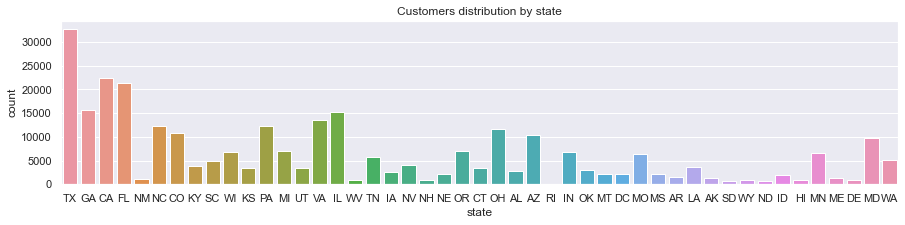

In [360]:
# Create plot
sns.set(font_scale=1,rc={'figure.figsize':(18, 4)})

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15,3))
plt.title('Customers distribution by state')
g=sns.countplot(df['state'])
# g.set(xticks=[2, 5,10])

[[<matplotlib.axis.XTick at 0x29639270520>,

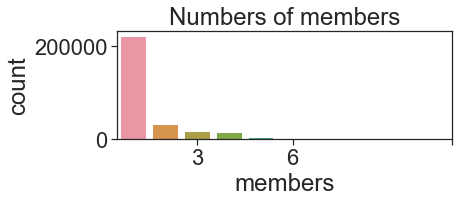

In [359]:
# Create plot
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(6,2))
plt.title('Numbers of members')
g=sns.countplot(df['members'])
g.set(xticks=[2, 5,10])

In [20]:
df=df.sort_values(by='carrier_name')

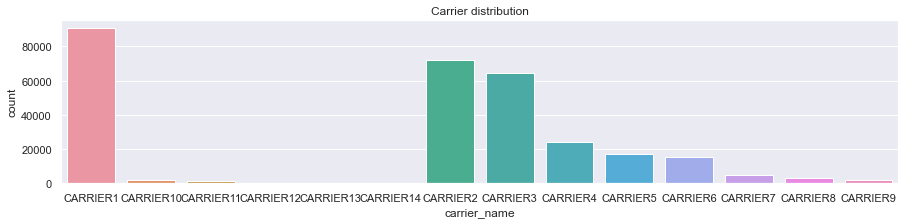

In [361]:
# Create plot
sns.set(font_scale=1,rc={'figure.figsize':(18, 4)})

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15,3))
plt.title('Carrier distribution')
g=sns.countplot(df['carrier_name'].sort_values())
# g.set(xticks=[0,3,6,9,12])

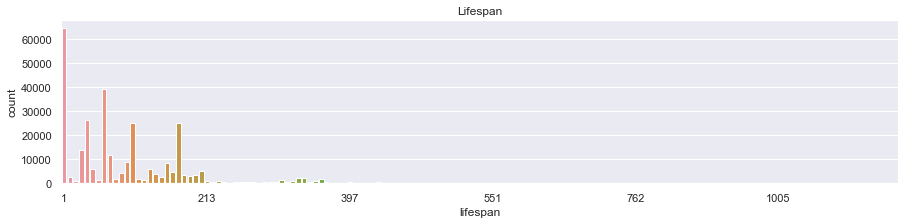

In [362]:
# Create plot
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15,3))
plt.title('Lifespan')
g=sns.countplot(df['lifespan'].sort_values())
g.set(xticks=[0,25,50,75,100,125,146])
plt.show()

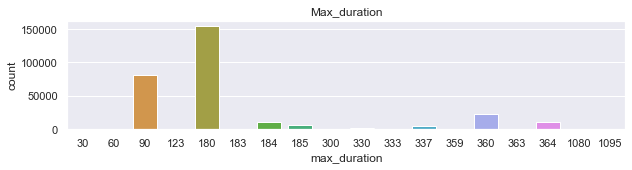

In [363]:
# Create plot
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,2))
plt.title('Max_duration')
g=sns.countplot(df['max_duration'])
# g.set(xticks=[0,3,6,9,12])

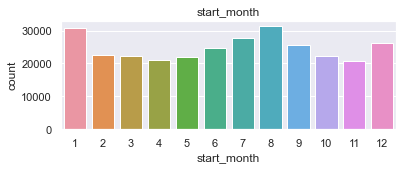

In [364]:
# Create plot
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(6,2))
plt.title('start_month')
g=sns.countplot(df['start_month'])
# g.set(xticks=[0,3,6,9,12])

In [25]:
df.describe()

,policy_number,start_month,members,max_duration,lifespan,duration_mon
count,2.975690e+05,297569.000000,297569.000000,297569.000000,297569.000000,297569.000000
mean,1.018391e+08,6.473534,1.495021,182.769788,90.330310,2.932382
std,8.572823e+06,3.466019,1.014617,95.494131,96.955889,3.183567
min,2.791784e+07,1.000000,1.000000,30.000000,1.000000,0.000000
25%,9.453583e+07,3.000000,1.000000,90.000000,31.000000,1.000000
50%,1.024964e+08,7.000000,1.000000,180.000000,62.000000,2.000000
75%,1.089867e+08,9.000000,2.000000,180.000000,152.000000,5.000000
max,1.210835e+08,12.000000,10.000000,1095.000000,1707.000000,56.000000


In [26]:
df.head()

,policy_number,start_date,start_month,churn_date,members,max_duration,state,carrier_name,lifespan,start_date_q,churn_date_q,duration_mon
109387,87161260,2015-01,1,2015-03,1,180,AL,CARRIER1,60,2015Q1,2015Q1,2
118371,96813775,2016-02,2,2016-07,1,180,TX,CARRIER1,152,2016Q1,2016Q3,5
118849,96629770,2016-02,2,2016-07,1,180,LA,CARRIER1,152,2016Q1,2016Q3,5
119051,96649545,2016-02,2,2016-07,1,180,KS,CARRIER1,152,2016Q1,2016Q3,5
119276,96632015,2016-02,2,2016-07,1,180,CA,CARRIER1,152,2016Q1,2016Q3,5


# Cohort Analysis


### 1. Based on year

In [27]:
df['duration_year']=df['churn_date'].dt.year-df['start_date'].dt.year+1
df['cohort_year']=df['start_date'].dt.year
#remove data that start date 
print(df[df['duration_year']<0].shape[0]/df.shape[0])
print('Invaild data is 0.39% of the total data, so we can remove them' )
df=df[df['duration_year']>=0]

0.0
Invaild data is 0.39% of the total data, so we can remove them


In [28]:
cohorts = df.groupby(['cohort_year','duration_year']).nunique()
cohorts = cohorts.policy_number.to_frame().reset_index()
cohorts = pd.pivot_table(cohorts, values = 'policy_number',index = 'cohort_year', columns= 'duration_year')
cohorts

duration_year,1,2,3,4,5,6
cohort_year,,,,,,
2015,61567.0,16229.0,62.0,5.0,1.0,5.0
2016,51915.0,12098.0,28.0,9.0,12.0,NaN
2017,43930.0,7129.0,535.0,290.0,NaN,NaN
2018,47701.0,14631.0,1720.0,NaN,NaN,NaN
2019,26533.0,13169.0,NaN,NaN,NaN,NaN


In [29]:
cohorts['total']=df.groupby('cohort_year').size()

<AxesSubplot:xlabel='duration_year', ylabel='cohort_year'>

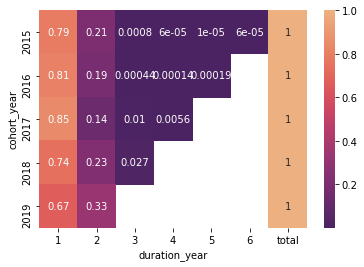

In [30]:
# Churn rate yearly Percentage
cohort_size=cohorts['total']
churn_year=round(cohorts.divide(cohort_size, axis=0),5)
#heatmap:
# plt.figure(figsize=(30,20))
sns.heatmap(data=churn_year,annot=True,
           cmap='flare_r')


In [31]:
#average retention rate:
average=pd.DataFrame(np.mean(churn_year, axis=0)).T
pd.concat([churn_year, average])


duration_year,1,2,3,4,5,6,total
2015,0.790650,0.208410,0.00080,0.00006,0.00001,0.00006,1.0
2016,0.810390,0.188850,0.00044,0.00014,0.00019,NaN,1.0
2017,0.846700,0.137400,0.01031,0.00559,NaN,NaN,1.0
2018,0.744720,0.228420,0.02685,NaN,NaN,NaN,1.0
2019,0.668300,0.331700,NaN,NaN,NaN,NaN,1.0
0,0.772152,0.218956,0.00960,0.00193,0.00010,0.00006,1.0


### 2. Based on Quarter

In [32]:
# based on quarter and create pivot table:
from operator import attrgetter
df['duration_q']=(df['churn_date_q']-df['start_date_q']).apply(attrgetter('n'))

In [33]:
#remove data that start date 
print(df[df['duration_q']<0].shape[0]/df.shape[0])
print('Invaild data is 0.42% of the total data, so we can remove them' )
df=df[df['duration_q']>=0]

0.0
Invaild data is 0.42% of the total data, so we can remove them


<AxesSubplot:xlabel='start_date_q', ylabel='count'>

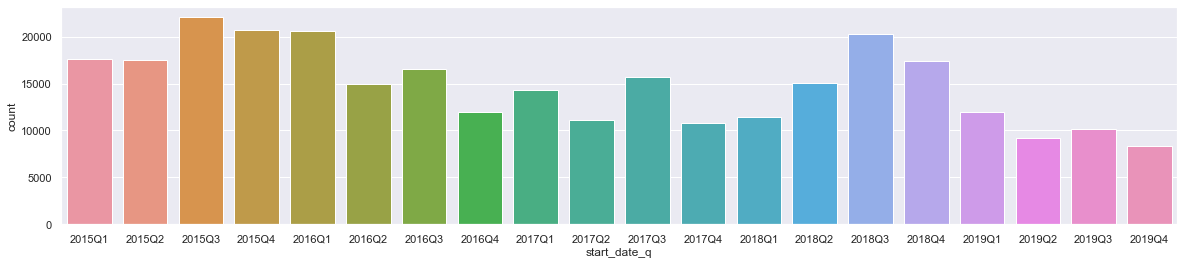

In [365]:
df=df.sort_values(by='start_date_q')
ax, fig=plt.subplots(figsize=(20,4))
sns.countplot(df['start_date_q'])

In [35]:
cohorts_q = df.groupby(['start_date_q','duration_q']).nunique()
cohorts_q = cohorts_q.policy_number.to_frame().reset_index()
cohorts_q.tail()

,start_date_q,duration_q,policy_number
174,2019Q3,0,2308
175,2019Q3,1,4124
176,2019Q3,2,3734
177,2019Q4,0,1759
178,2019Q4,1,6621


In [36]:
cohorts_q = pd.pivot_table(cohorts_q, values = 'policy_number',index = 'start_date_q', columns= 'duration_q')
cohorts_q['total']=df.groupby('start_date_q').size()

<AxesSubplot:xlabel='duration_q', ylabel='start_date_q'>

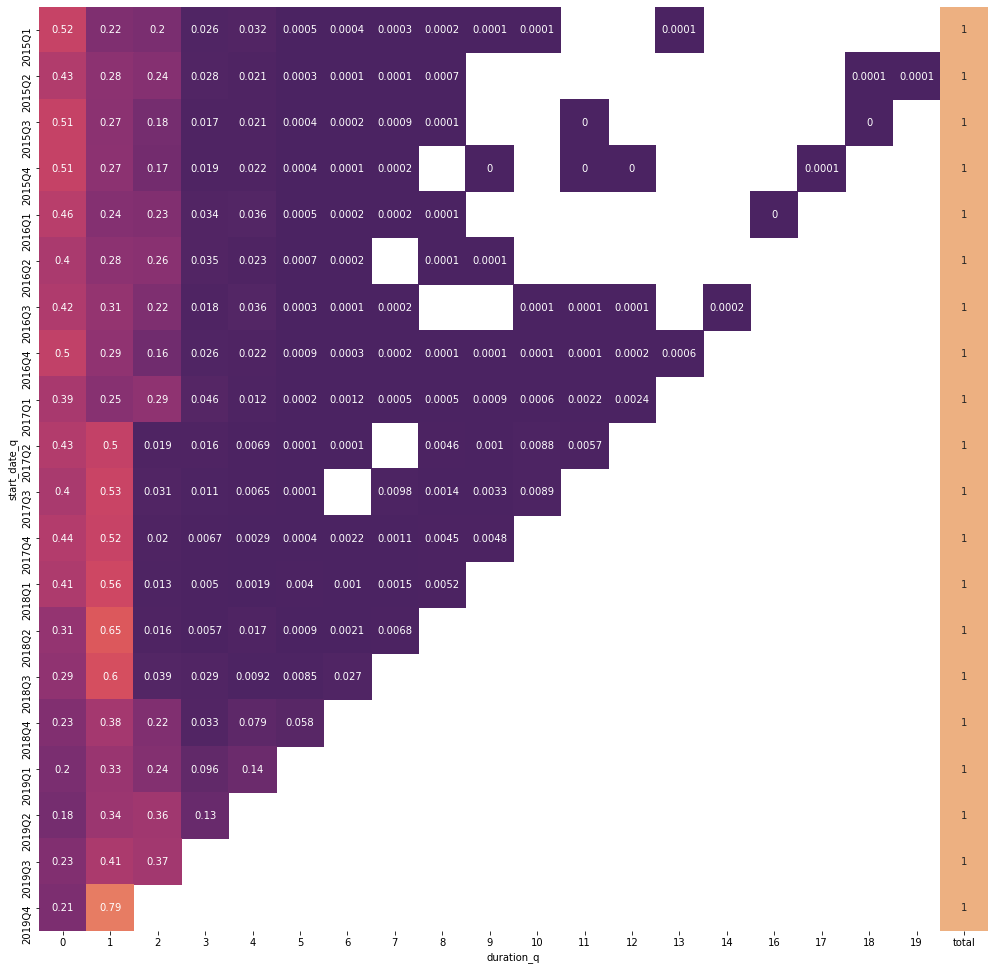

In [37]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(17,17))
#Percentage
cohort_size=cohorts_q['total']
churn_quarter=round(cohorts_q.divide(cohort_size, axis=0),4)
sns.heatmap(data=churn_quarter,annot=True,
           cmap='flare_r',cbar=False)

In [38]:
#average retention rate:
average=pd.DataFrame(np.mean(churn_quarter, axis=0)).T
pd.concat([churn_quarter, average])

duration_q,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,16,17,18,19,total
2015Q1,0.51770,0.21910,0.203100,0.026300,0.032200,0.00050,0.000400,0.000300,0.000200,0.000100,0.0001,NaN,NaN,0.00010,NaN,NaN,NaN,NaN,NaN,1.0
2015Q2,0.43000,0.27660,0.243000,0.027900,0.021100,0.00030,0.000100,0.000100,0.000700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00010,0.0001,1.0
2015Q3,0.51210,0.27150,0.176500,0.017100,0.021000,0.00040,0.000200,0.000900,0.000100,NaN,NaN,0.00000,NaN,NaN,NaN,NaN,NaN,0.00000,NaN,1.0
2015Q4,0.51390,0.27370,0.169800,0.019200,0.022300,0.00040,0.000100,0.000200,NaN,0.000000,NaN,0.00000,0.000000,NaN,NaN,NaN,0.0001,NaN,NaN,1.0
2016Q1,0.46070,0.24010,0.228800,0.033700,0.035700,0.00050,0.000200,0.000200,0.000100,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0
2016Q2,0.40120,0.27680,0.262900,0.035100,0.023000,0.00070,0.000200,NaN,0.000100,0.000100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2016Q3,0.41930,0.30930,0.216400,0.018300,0.035600,0.00030,0.000100,0.000200,NaN,NaN,0.0001,0.00010,0.000100,NaN,0.0002,NaN,NaN,NaN,NaN,1.0
2016Q4,0.49850,0.29140,0.159500,0.026000,0.022200,0.00090,0.000300,0.000200,0.000100,0.000100,0.0001,0.00010,0.000200,0.00060,NaN,NaN,NaN,NaN,NaN,1.0
2017Q1,0.39200,0.25400,0.287200,0.046200,0.012200,0.00020,0.001200,0.000500,0.000500,0.000900,0.0006,0.00220,0.002400,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2017Q2,0.43390,0.50400,0.019200,0.015800,0.006900,0.00010,0.000100,NaN,0.004600,0.001000,0.0088,0.00570,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


### 3. Based on month

In [39]:
from operator import attrgetter
df['duration_mon']=(df['churn_date']-df['start_date']).apply(attrgetter('n'))
#remove data that start date 
print(df[df['duration_mon']<0].shape[0]/df.shape[0])
df=df[df['duration_mon']>=0]

0.0


In [40]:
df=df.sort_values(by=['start_date','churn_date'])

In [41]:
cohorts = df.groupby(['start_date','duration_mon']).nunique()
cohorts = cohorts.policy_number.to_frame().reset_index()
cohorts = pd.pivot_table(cohorts, values = 'policy_number',index = 'start_date', columns= 'duration_mon')
cohorts.head()

duration_mon,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,48,50,51,53,56
start_date,,,,,,,,,,,,,,,,,,,,,
2015-01,3002.0,1127.0,627.0,295.0,195.0,952.0,184.0,24.0,25.0,16.0,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
2015-02,1755.0,1040.0,462.0,319.0,235.0,1323.0,184.0,37.0,26.0,19.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-03,1586.0,747.0,370.0,292.0,272.0,1154.0,382.0,22.0,24.0,52.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-04,1601.0,771.0,413.0,365.0,256.0,1411.0,288.0,36.0,48.0,35.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-05,1794.0,856.0,421.0,312.0,257.0,1455.0,253.0,67.0,41.0,32.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [366]:
a=np.sum(cohorts, axis=1)
cohorts['total']=a
cols=cohorts.columns

In [43]:
cohorts_retention=pd.DataFrame()
inter=cohorts['total']
for i in range(len(cols)-1):
    inter = inter - cohorts[cols[i]]
    cohorts_retention[str(cols[i])+' month']=inter

In [44]:
cohorts_retention['total']=a

In [137]:
cohorts_retention.head()

,0 month,1 month,2 month,3 month,4 month,5 month,6 month,7 month,8 month,9 month,...,39 month,40 month,41 month,42 month,48 month,50 month,51 month,53 month,56 month,total
start_date,,,,,,,,,,,,,,,,,,,,,
2015-01,3721.0,2594.0,1967.0,1672.0,1477.0,525.0,341.0,317.0,292.0,276.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6723.0
2015-02,3947.0,2907.0,2445.0,2126.0,1891.0,568.0,384.0,347.0,321.0,302.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5702.0
2015-03,3638.0,2891.0,2521.0,2229.0,1957.0,803.0,421.0,399.0,375.0,323.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5224.0
2015-04,3861.0,3090.0,2677.0,2312.0,2056.0,645.0,357.0,321.0,273.0,238.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5462.0
2015-05,3883.0,3027.0,2606.0,2294.0,2037.0,582.0,329.0,262.0,221.0,189.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5677.0


In [ ]:
r=pd.DataFrame()
for i in range(len(cols)-1):
    r[str(cols[i+1])+' month']=cohorts_retention.iloc[:,i+1]/cohorts_retention.iloc[:,i]
r['0 month']=1.0
#heatmap:
# plt.figure(figsize=(30,20))
sns.heatmap(data=r,
           cmap='flare',cbar=False)
r.head()

<AxesSubplot:title={'center':'Monthly Retention Rate'}, xlabel='start_date'>

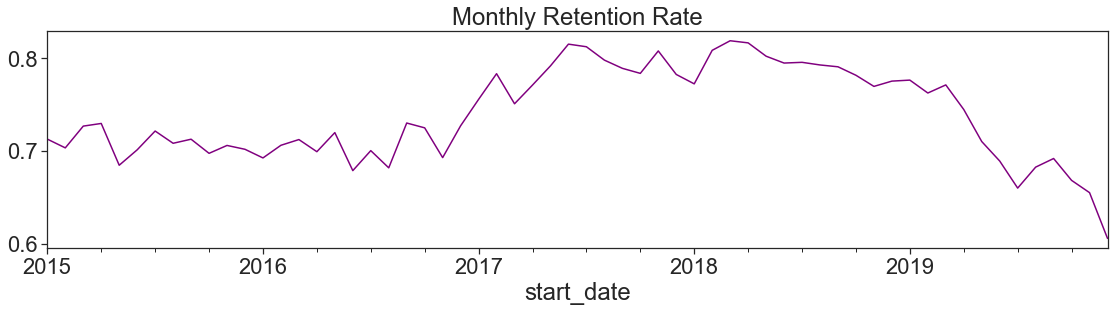

In [354]:
r['retention_rate']=np.mean(r, axis=1)
fig, ax = plt.subplots(figsize=(19,4))
plt.title('Monthly Retention Rate')
r['retention_rate'].plot()

In [352]:
res=r['retention_rate']
res=res.to_frame().reset_index(drop=True)

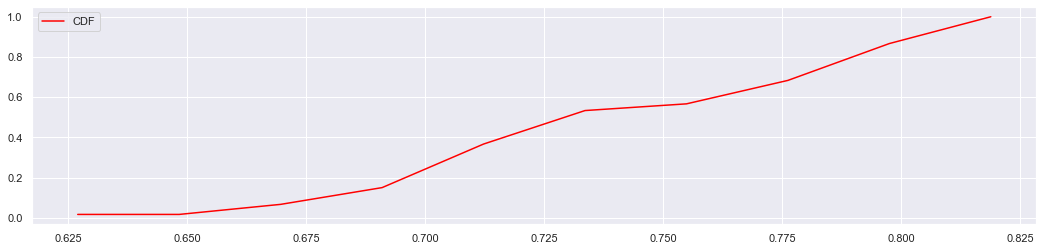

In [367]:
import matplotlib.pyplot as plt 
import numpy as np 
count, bins_count = np.histogram(res, bins=10)
# finding the PDF of the histogram using count values
pdf = count / sum(count)
# using numpy np.cumsum to calculate the CDF
# We can also find using the PDF values by looping and adding
cdf = np.cumsum(pdf)
# plotting PDF and CDF
plt.plot(bins_count[1:], cdf, color='red',label="CDF")
plt.legend()

<AxesSubplot:title={'center':'Average Monthly Retention Rate'}, xlabel='retention_rate', ylabel='Proportion'>

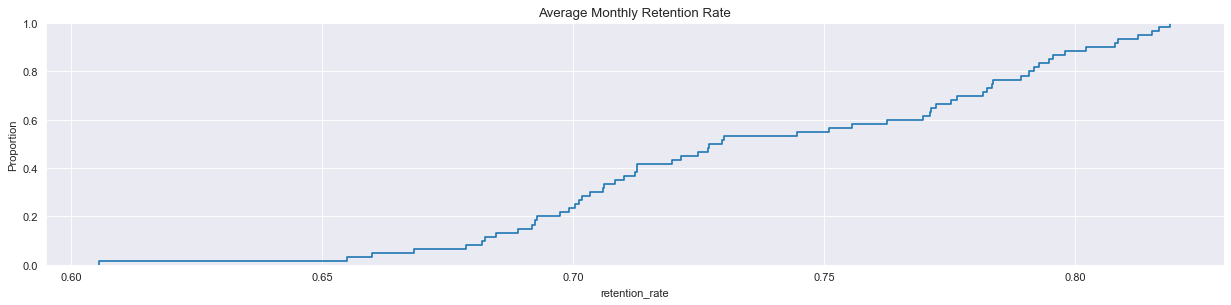

In [188]:
fig, ax = plt.subplots(figsize=(19,4),dpi=80)
plt.title('Average Monthly Retention Rate')
sns.ecdfplot(data=res, x='retention_rate')

In [114]:
col_name="total"
first_col =retention_month.pop(col_name)
retention_month.insert(0, col_name, first_col)

<AxesSubplot:ylabel='start_date'>

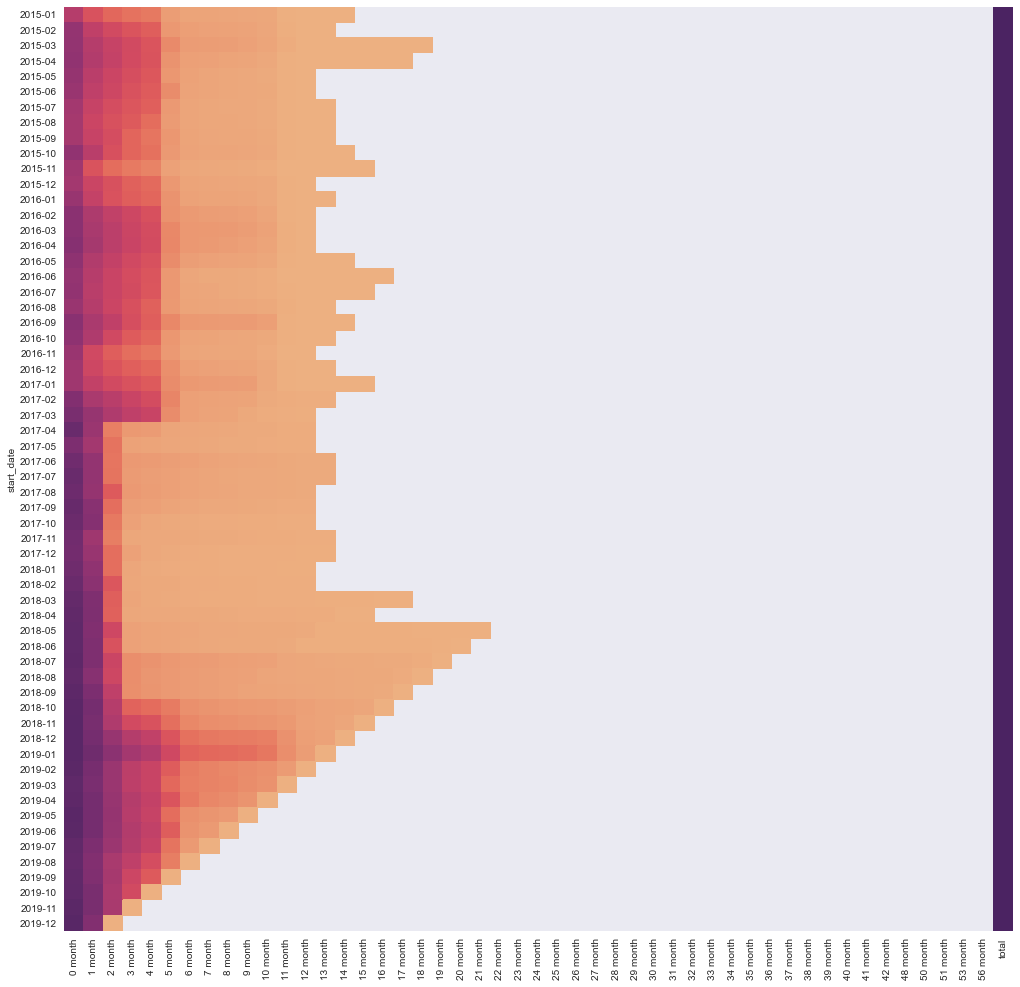

In [112]:
#Percentage
fig, ax = plt.subplots(figsize=(17,17))
cohort_size=cohorts_retention['total']
retention_month=round(cohorts_retention.divide(cohort_size, axis=0),6)
#heatmap:
# plt.figure(figsize=(30,20))
sns.heatmap(data=retention_month,
           cmap='flare',cbar=False)

In [121]:
retention_month.head()

,total,0 month,1 month,2 month,3 month,4 month,5 month,6 month,7 month,8 month,...,38 month,39 month,40 month,41 month,42 month,48 month,50 month,51 month,53 month,56 month
start_date,,,,,,,,,,,,,,,,,,,,,
2015-01,1.0,0.553473,0.385840,0.292578,0.248698,0.219694,0.078090,0.050721,0.047152,0.043433,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-02,1.0,0.692213,0.509821,0.428797,0.372852,0.331638,0.099614,0.067345,0.060856,0.056296,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-03,1.0,0.696401,0.553407,0.482580,0.426685,0.374617,0.153714,0.080590,0.076378,0.071784,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-04,1.0,0.706884,0.565727,0.490114,0.423288,0.376419,0.118089,0.065361,0.058770,0.049982,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-05,1.0,0.683988,0.533204,0.459045,0.404087,0.358816,0.102519,0.057953,0.046151,0.038929,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [123]:
retention_month['retention_rate']=np.mean(retention_month, axis=1)

<AxesSubplot:title={'center':'Monthly Retention Rate'}, xlabel='start_date'>

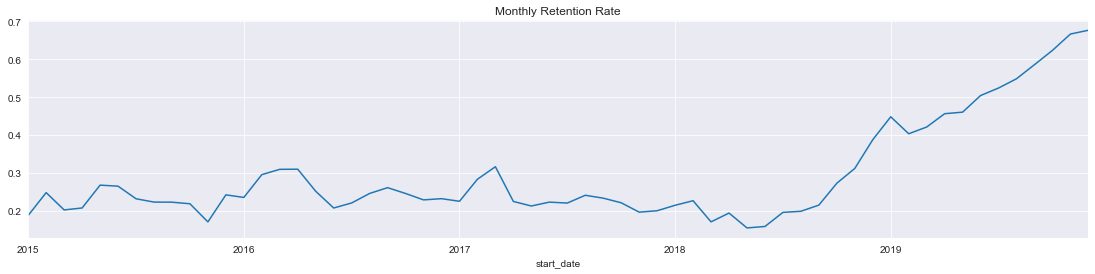

In [189]:
fig, ax = plt.subplots(figsize=(19,4))
plt.title('Monthly Retention Rate')
retention_month['retention_rate'].plot()

The retention rate in the end of 2019 is super high because we did not have more data in 2020 so I am considering to remove it.

In [130]:
res=retention_month['retention_rate']

In [134]:
res=retention_month['retention_rate']
res=res.to_frame().reset_index(drop=True)

<AxesSubplot:title={'center':'Average Monthly Retention Rate'}, xlabel='retention_rate', ylabel='Proportion'>

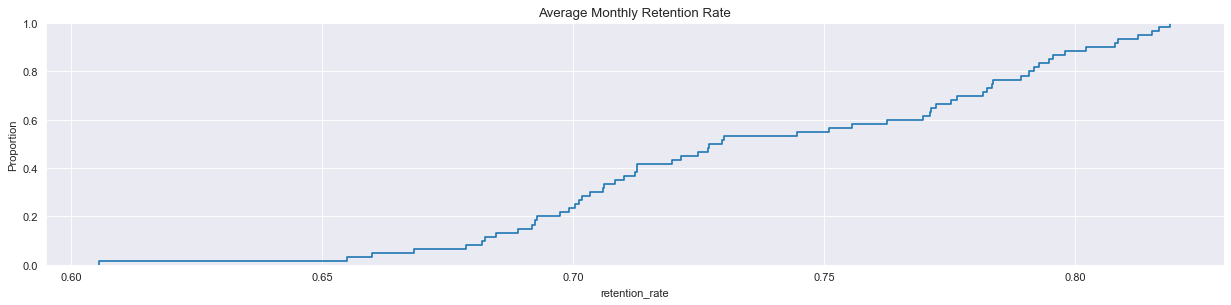

In [190]:
fig, ax = plt.subplots(figsize=(19,4),dpi=80)
plt.title('Average Monthly Retention Rate')
sns.ecdfplot(data=res, x='retention_rate')

## 1. Are there any factors that impact the length of member Lifetime? 
- Cohort-level
- Dependent variable: Length of memeber lifetime
- Factors: Importance feature selection:
    - 1. Corrletion
    - 2. RFE Cross-validation
    - 3. Multiple Linear Regression
    - 4. Random Forest

Based on monthly cohort, every cohort has a average retention rate. Based on retention rate, we can calculate average length of memeber lifetime based on cohort.

# Feature importance ranking
#### 1. Correlation metrics

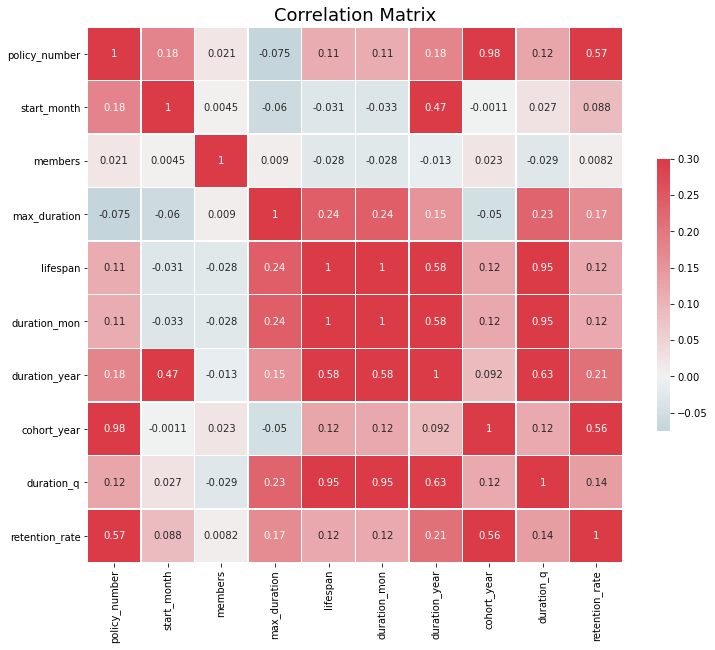

In [55]:
corr1=df.corr()
f, ax = plt.subplots(figsize=(12, 10))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
plt.title('Correlation Matrix', fontsize=18)
heatmap1=sns.heatmap(corr1,  cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

Based on correlation metrics, we can see that lifetime has a strong positive correlation with how long they stayed with us.
The longer they stay with us, the longer lifetime they will have.

### 2.RFE Cross-validation

In [85]:
# prepare data:
model=df[['start_month', 'members',
       'max_duration', 'state', 'carrier_name', 'lifespan', 
        'duration_mon','retention_rate']]
model=pd.get_dummies(model)
X=model.drop('lifespan',axis=1)
y=model['lifespan']

In [86]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
# Normalization:
scaler = StandardScaler()
X_train=scaler.fit_transform(X)

In [87]:
# from sklearn.feature_selection import RFECV
# from sklearn.svm import SVR
# estimator = SVR()
# selector = RFECV(step=20,estimator=estimator)
# selector = selector.fit(X, y)
# # df3=pd.DataFrame()
# # df3['rank']=selector.ranking_

In [88]:
# feature_imp = pd.Series(selector.ranking_,index=X.columns).sort_values()
# feature_imp
# # Creating a bar plot
# sns.barplot(x=feature_imp, y=feature_imp.index)
# # Add labels to your graph
# plt.xlabel('Feature Importance Score')
# plt.ylabel('Features')
# plt.title("Visualizing Important Features")

### 3. Multiple Linear Regression

In [89]:
from sklearn.linear_model import LinearRegression
lr=LinearRegression()
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
kfold = model_selection.KFold(n_splits=10, random_state=7)
modelCV = LinearRegression()
modelCV.fit(X, y)

C:\Users\Rachel\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:292: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [90]:
feature_positive = pd.Series(modelCV.coef_,index=X .columns).sort_values(ascending=False)
feature_positive[:10]

duration_mon              30.454838
retention_rate             0.522625
carrier_name_CARRIER11     0.324646
carrier_name_CARRIER8      0.312853
state_WA                   0.146161
carrier_name_CARRIER6      0.118341
state_AK                   0.079944
carrier_name_CARRIER1      0.074147
state_CA                   0.069722
carrier_name_CARRIER10     0.067158
dtype: float64

In [91]:
feature_negative = pd.Series(modelCV.coef_,index=X .columns).sort_values()
feature_negative[:10]

carrier_name_CARRIER14   -0.456611
carrier_name_CARRIER13   -0.321934
carrier_name_CARRIER7    -0.195740
state_RI                 -0.154223
state_MN                 -0.043630
state_OK                 -0.041947
carrier_name_CARRIER9    -0.037637
state_DE                 -0.034245
state_SD                 -0.031670
state_MS                 -0.030866
dtype: float64

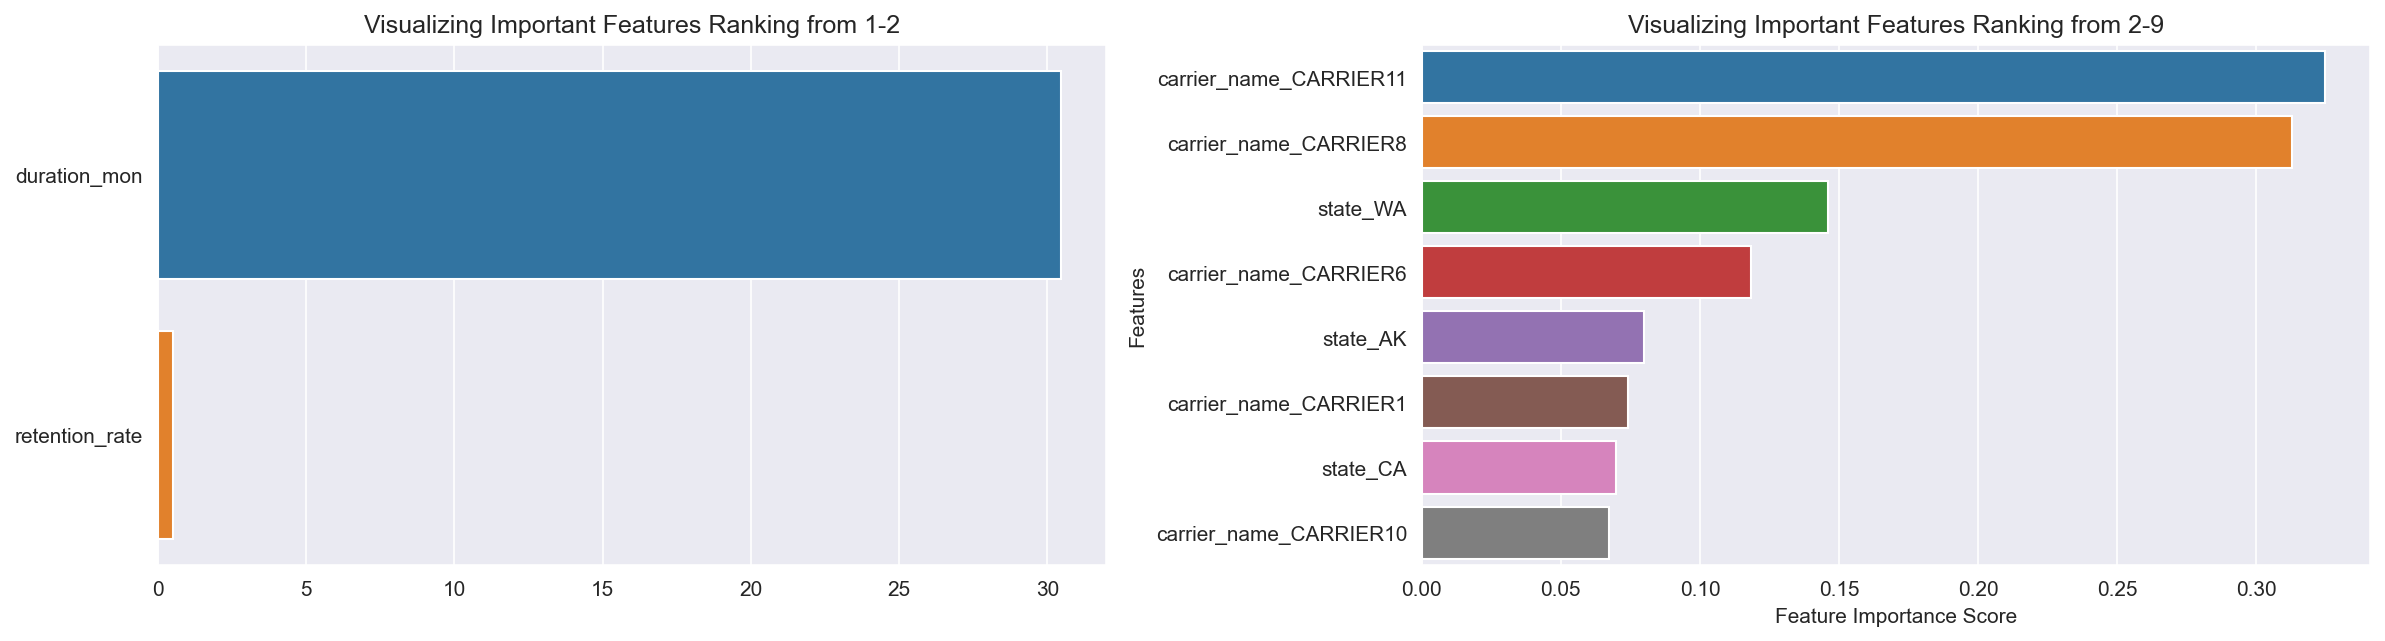

In [98]:
# Creating a bar plot
plt.figure(figsize=(16,8),dpi=150)
plt.ticklabel_format(useOffset=False)
plt.subplot(2,2,1)
plt.title("Visualizing Important Features Ranking from 1-2")
sns.barplot(x=feature_positive[0:2], y=feature_positive.index[0:2])
plt.subplot(2,2,2)
plt.title("Visualizing Important Features Ranking from 2-9")
sns.barplot(x=feature_positive[2:10], y=feature_positive.index[2:10])
# plt.subplot(2,2,3)
# plt.title("Visualizing Important Features Ranking from 1-2")
# sns.barplot(x=feature_negative[0:2], y=feature_negative.index[0:2])
# plt.subplot(2,2,4)
# sns.barplot(x=feature_negative[2:10], y=feature_negative.index[2:10])
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features Ranking from 2-9")
plt.tight_layout()

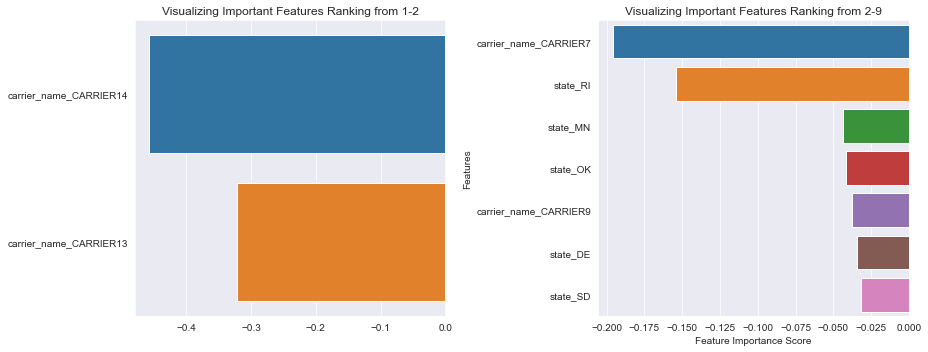

In [102]:
# Creating a bar plot
plt.figure(figsize=(13,5))
plt.ticklabel_format(useOffset=False)
sns.set_style("darkgrid")
plt.subplot(1,2,1)
plt.title("Visualizing Important Features Ranking from 1-2")
sns.barplot(x=feature_negative[0:2], y=feature_negative.index[0:2])
plt.subplot(1,2,2)
sns.barplot(x=feature_negative[2:9], y=feature_negative.index[2:9])
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features Ranking from 2-9")
plt.tight_layout()

### 4. Random Forest

In [103]:
from sklearn.ensemble import RandomForestRegressor
# use 10 trees for starter and just default setting to train the first ensembled tree
regressor = RandomForestRegressor(n_estimators = 10, random_state = 42)
regressor.fit(X, y)
feature_imp = pd.Series(regressor.feature_importances_,index=X.columns).sort_values(ascending=False)
feature_imp[:10]

duration_mon             9.999241e-01
start_month              6.521824e-05
retention_rate           8.584926e-06
state_MD                 1.006094e-06
max_duration             5.653228e-07
carrier_name_CARRIER1    1.725969e-07
carrier_name_CARRIER2    7.859397e-08
state_FL                 6.006827e-08
carrier_name_CARRIER4    5.606155e-08
state_VA                 4.188427e-08
dtype: float64

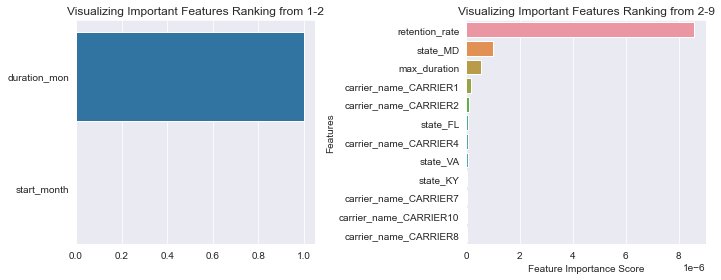

In [104]:
# Creating a bar plot
plt.figure(figsize=(10,4))
plt.ticklabel_format(useOffset=False)
sns.set_style("darkgrid")
plt.subplot(1,2,1)
plt.title("Visualizing Important Features Ranking from 1-2")
sns.barplot(x=feature_imp[0:2], y=feature_imp.index[0:2])
plt.subplot(1,2,2)
sns.barplot(x=feature_imp[2:14], y=feature_imp.index[2:14])
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features Ranking from 2-9")
plt.tight_layout()

## 2.What does Monthly Retention Curve look like? How about Cumulative Retention Curve? 

**Monthly Retention Rates across the cohort lifetime (MRR)**

-	Defined as: Retained members at month t/Retained members at month t-1 
-	This metric changes across the months in the cohort lifetime


### Monthly Retention Curve 

In [ ]:
# Retention Rate plot by time
sns.set(font_scale=2,rc={'figure.figsize':(18, 4)})
sns.set_palette("brg",3)
sns.set_style("ticks")
plt.title('Retention Rate plot by time')
sns.lineplot(data=res, x="duration_mon",linewidth=4, y="retention_rate",label='retention rate')
plt.ylabel("Retention Rate")
plt.title("Monthly Retention Curve ")

In [ ]:
mon=retention_month.iloc[:,:20]
mon=mon.T
mon1=mon.iloc[:,:12]
mon2=mon.iloc[:,12:24]
mon3=mon.iloc[:,24:36]
mon4=mon.iloc[:,36:48]
mon5=mon.iloc[:,48:62]

In [ ]:
color=['teal', 'maroon', 'blue', 'brown', 'cyan', 'yellow', 'orange', 'purple', 'red', 'green', 'magenta']
# sns.set_palette("rainbow_r",3)

fig, ax = plt.subplots(nrows=5, ncols=1,figsize=(20,20),dpi=80)

mon1.plot(linewidth=1, color=color,ax=ax[0])
plt.title('Retention Rate in 2015')

mon2.plot(linewidth=1, color=color, ax=ax[1])
plt.title('Retention Rate in 2016')

mon3.plot(linewidth=1, color=color, ax=ax[2])
plt.title('Retention Rate in 2017')

mon4.plot(linewidth=1, color=color, ax=ax[3])
plt.title('Retention Rate in 2018')

mon5.plot( linewidth=1, color=color, ax=ax[4])
plt.title('Retention Rate in 2019')
plt.xlabel('Months')
plt.subplots_adjust() 
plt.legend()

#### Average Monthly Retention Rate Cummlative Distribution

In [ ]:
fig, ax = plt.subplots(figsize=(10,3),dpi=80)
plt.title('Average Monthly Retention Rate')
sns.ecdfplot(data=res, x='retention_rate')

## 3.(1) 3.	What would be your statistical approach to predict Cumulative Retention Curve for 2019 cohorts using previous years’ data? 

In [209]:
res=r['retention_rate'].to_frame().reset_index()
df=pd.merge(df, res, how='left',left_on='start_date',right_on='start_date')

In [211]:
df.columns

Index(['policy_number', 'start_date', 'start_month', 'churn_date', 'members',
       'max_duration', 'state', 'carrier_name', 'lifespan', 'start_date_q',
       'churn_date_q', 'duration_mon', 'duration_year', 'cohort_year',
       'duration_q', 'retention_rate_x', 'retention_rate_y'],
      dtype='object')

In [213]:
df=df[['policy_number', 'start_date', 'start_month', 'churn_date', 'members',
       'max_duration', 'state', 'carrier_name', 'lifespan', 'start_date_q',
       'churn_date_q', 'duration_mon', 'duration_year', 'cohort_year',
       'duration_q', 'retention_rate_y']]

In [214]:
df.columns=['policy_number', 'start_date', 'start_month', 'churn_date', 'members',
       'max_duration', 'state', 'carrier_name', 'lifespan', 'start_date_q',
       'churn_date_q', 'duration_mon', 'duration_year', 'cohort_year',
       'duration_q', 'retention_rate']

In [215]:
df_train=df[df['start_date']<'2019-01']
df_test=df[df['start_date']>='2019-01']

In [216]:
df_train.head()

,policy_number,start_date,start_month,churn_date,members,max_duration,state,carrier_name,lifespan,start_date_q,churn_date_q,duration_mon,duration_year,cohort_year,duration_q,retention_rate
0,86956520,2015-01,1,2015-01,1,180,TX,CARRIER1,1,2015Q1,2015Q1,0,1,2015,0,0.712772
1,86789550,2015-01,1,2015-01,1,180,GA,CARRIER1,1,2015Q1,2015Q1,0,1,2015,0,0.712772
2,85966580,2015-01,1,2015-01,1,180,CA,CARRIER1,1,2015Q1,2015Q1,0,1,2015,0,0.712772
3,86199470,2015-01,1,2015-01,1,180,FL,CARRIER1,1,2015Q1,2015Q1,0,1,2015,0,0.712772
4,87047235,2015-01,1,2015-01,4,180,CA,CARRIER1,1,2015Q1,2015Q1,0,1,2015,0,0.712772


In [217]:
df_train.shape[0]

257867

In [218]:
df_train=df[df['start_date']<'2019-01']
df_test=df[df['start_date']>='2019-01']
n_train=df_train.shape[0]
n_test=df_test.shape[0]
df_model=df[[ 'start_month', 'members',
       'max_duration', 'state', 'carrier_name', 'lifespan', 
        'duration_mon', 'duration_year', 'cohort_year',
       'duration_q', 'retention_rate']]

In [219]:
df_model=pd.get_dummies(df_model)

In [220]:
df_model.shape

(297569, 70)

In [221]:
n_test

39702

In [222]:
df_train=df_model[:n_train]
df_test=df_model[n_train:]

In [223]:
X_train=df_train.drop(columns={'retention_rate'})
y_train=df_train['retention_rate']

X_test=df_test.drop(columns={'retention_rate'})
y_test=df_test['retention_rate']

In [224]:
# Normalization:
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.fit_transform(X_test)

In [225]:
X_train.shape,y_train.shape

((257867, 69), (257867,))

In [226]:
X_test.shape

(39702, 69)

In [227]:
X_train

array([[-1.60453276, -0.48452945,  0.03622167, ..., -0.14081798,
        -0.10638839, -0.09117619],
       [-1.60453276, -0.48452945,  0.03622167, ..., -0.14081798,
        -0.10638839, -0.09117619],
       [-1.60453276, -0.48452945,  0.03622167, ..., -0.14081798,
        -0.10638839, -0.09117619],
       ...,
       [ 1.58543593, -0.48452945,  2.29321261, ..., -0.14081798,
        -0.10638839, -0.09117619],
       [ 1.58543593, -0.48452945,  0.03622167, ..., -0.14081798,
        -0.10638839, -0.09117619],
       [ 1.58543593, -0.48452945,  2.29321261, ..., -0.14081798,
        -0.10638839, -0.09117619]])

In [229]:
# scikit Linear Regression by default uses L2 regularization
from sklearn.linear_model import LinearRegression
lin_reg_sklearn = LinearRegression(fit_intercept = True, normalize = False)
lin_reg_sklearn.fit(X_train, y_train)
y_pred_lin= lin_reg_sklearn.predict(X_test)
evaluation(y_test, y_pred_lin)

root mean square error:  10802682844.138575
mean square error:  1.166979566310459e+20
explained_variance_score:  -4.206393749543392e+22
max_error:  222713545239.67764
mean_absolute_error:  7970959313.95779
median_absolute_error:  4489607985.946214
r2_score:  -4.206393749543392e+22


In [232]:
X_train

array([[-1.60453276, -0.48452945,  0.03622167, ..., -0.14081798,
        -0.10638839, -0.09117619],
       [-1.60453276, -0.48452945,  0.03622167, ..., -0.14081798,
        -0.10638839, -0.09117619],
       [-1.60453276, -0.48452945,  0.03622167, ..., -0.14081798,
        -0.10638839, -0.09117619],
       ...,
       [ 1.58543593, -0.48452945,  2.29321261, ..., -0.14081798,
        -0.10638839, -0.09117619],
       [ 1.58543593, -0.48452945,  0.03622167, ..., -0.14081798,
        -0.10638839, -0.09117619],
       [ 1.58543593, -0.48452945,  2.29321261, ..., -0.14081798,
        -0.10638839, -0.09117619]])

## XGBT

In [295]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error

In [296]:
xgbr = xgb.XGBRegressor(verbosity=0) 
xgbr.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=0)

In [297]:
score = xgbr.score(X_train, y_train)  
print("Training score: ", score)

Training score:  0.9999872275707091


In [298]:
ypred = xgbr.predict(X_test)
mse = mean_squared_error(y_test, ypred)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % (mse**(1/2.0)))

MSE: 0.00
RMSE: 0.06


In [344]:
evaluation(y_test, ypred)

root mean square error:  0.06
mean square error:  0.0
explained_variance_score:  -0.14
max_error:  0.12
mean_absolute_error:  0.05
median_absolute_error:  0.04


## 3.(2) How is it validated against the actual curve observed? 

In [301]:
df_train=df[df['start_date']<'2019-01']
df_test=df[df['start_date']>='2019-01']

In [302]:
test=df_test[['start_date','retention_rate']]
test['ypred']=ypred

<ipython-input-302-b3e719972c69>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ypred']=ypred


In [303]:
test.index=test['start_date']
test=test[['retention_rate', 'ypred']]

In [304]:
test.head()

,retention_rate,ypred
start_date,,
2019-01,0.77643,0.706097
2019-01,0.77643,0.706097
2019-01,0.77643,0.706097
2019-01,0.77643,0.706097
2019-01,0.77643,0.706097


In [278]:
test.shape
test=test.drop_duplicates()

<AxesSubplot:xlabel='start_date'>

<Figure size 1872x576 with 0 Axes>

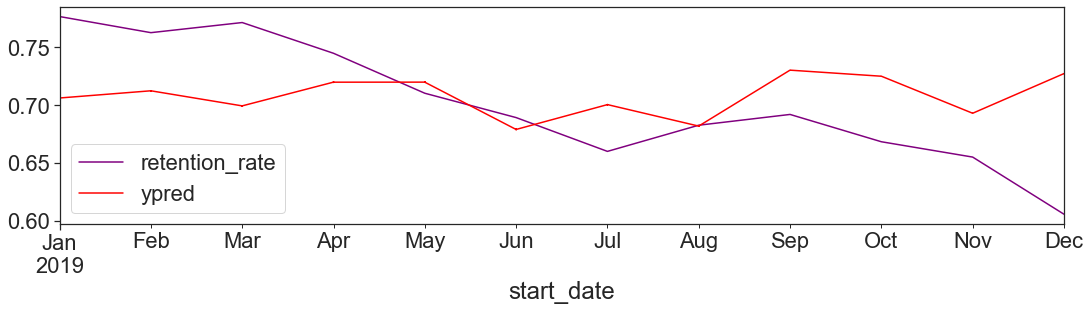

In [305]:
plt.figure(figsize = (26, 8))
test.plot()

## Predictive Cumulative Retention Curve for 2019

In [322]:
real=test['retention_rate'].to_frame().reset_index()
ypred=test['ypred'].to_frame().reset_index()

<AxesSubplot:title={'center':'Average Monthly Retention Rate'}, xlabel='retention_rate', ylabel='Proportion'>

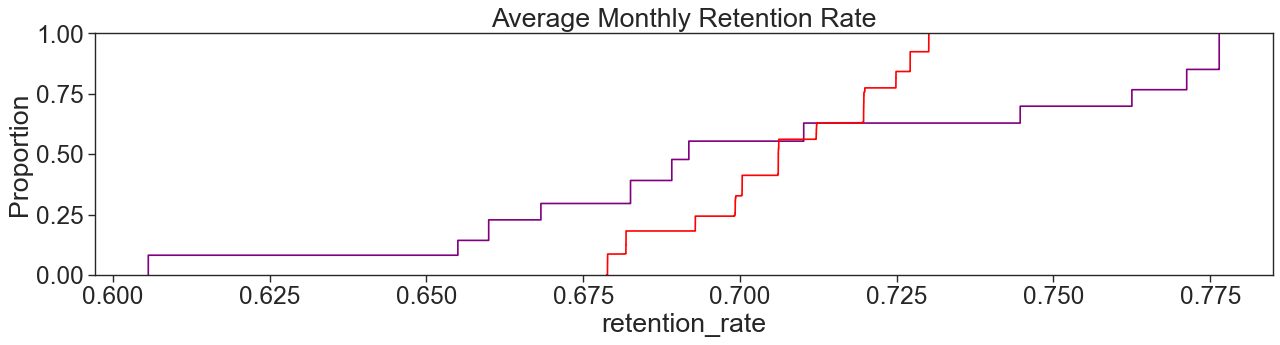

In [323]:
fig, ax = plt.subplots(figsize=(19,4),dpi=80)
plt.title('Average Monthly Retention Rate')
sns.ecdfplot(data=real, x='retention_rate')
sns.ecdfplot(data=ypred, x='ypred')

In [324]:
real=real.drop('start_date', axis=1)

In [325]:
ypred

,start_date,ypred
0,2019-01,0.706097
1,2019-01,0.706097
2,2019-01,0.706097
3,2019-01,0.706097
4,2019-01,0.706097
...,...,...
39697,2019-12,0.727145
39698,2019-12,0.727145
39699,2019-12,0.727145
39700,2019-12,0.727145


In [326]:
ypred=ypred.drop('start_date', axis=1)

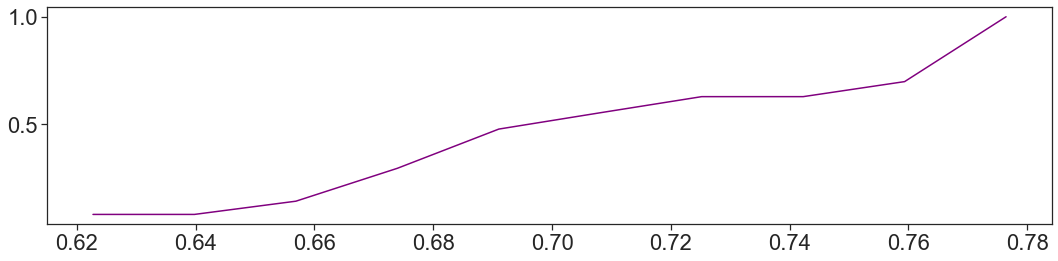

In [329]:
count, bins_count = np.histogram(real, bins=10)
# finding the PDF of the histogram using count values
pdf = count / sum(count)
# using numpy np.cumsum to calculate the CDF
# We can also find using the PDF values by looping and adding
cdf = np.cumsum(pdf)
# plotting PDF and CDF
plt.plot(bins_count[1:], cdf, label="real_CDF")

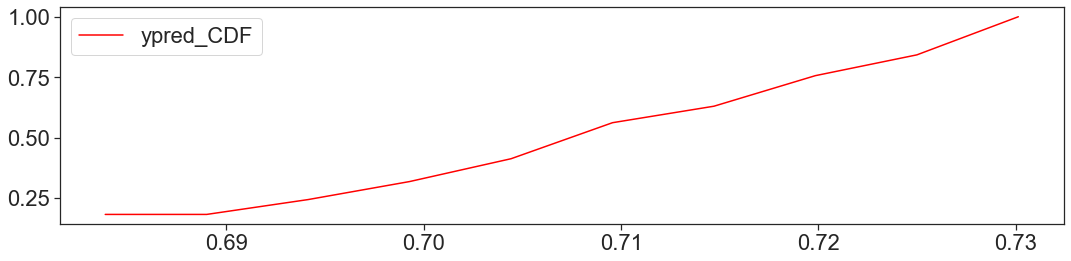

In [330]:
count, bins_count = np.histogram(ypred, bins=10)
# finding the PDF of the histogram using count values
pdf = count / sum(count)
# using numpy np.cumsum to calculate the CDF
# We can also find using the PDF values by looping and adding
cdf = np.cumsum(pdf)
# plotting PDF and CDF
plt.plot(bins_count[1:], cdf, color='red',label="ypred_CDF")
plt.legend()